In [1]:
%load_ext rpy2.ipython

/Users/cc1333/Library/Python/3.9/lib/python/site-packages/rpy2/ipython/rmagic.py:77: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded (error: No module named 'pandas'), but at least we found `numpy`.
  warnings.warn('The Python package `pandas` is strongly '


In [2]:
%%R
suppressPackageStartupMessages({
  suppressMessages({
    library(parallel)
    library(parallelly)
  })
})

# Parallelisation Using the `parallel` Package
The following section is based off of [these notes](https://dept.stat.lsa.umich.edu/~jerrick/courses/stat506_f24/16-parallel-processing.html) written by Josh Errickson at the University of Michigan. Additional information can be found in the [documentation](https://stat.ethz.ch/R-manual/R-devel/library/parallel/doc/parallel.pdf) for the parallel package.

## Overview
Suppose you have found yourself in one of the following situations:

1.    You have a function $f$ that you need to run **many** times for different input values. 
2.    You have a large set of functions $f_1, \, \dots\, , f_n$, $n>>1$, that you need to run, each for potentially many different input values.

If you're like me, you'd probably prefer to get straight to analyzing the data produced by the functions as opposed to waiting around all day for them to finish running. This is where parallelization can help you.

We consider the case here where each function evaluation is completely independent of the others. In case 1 above, this is trivial because you're just running the same function for many different input combinations. In the second scenario, this means that the functions are completely unrelated e.g. the output of one function is never used as the input to another.

A core on your computer can be thought of as an individual unit that can execute tasks. The vast majority of modern computers have multiple cores and parallelising your code involves sending independent jobs to different cores on your computer. In `R` one way of doing this is by using a concept called **forking**. 

## Forking (Will not work on Windows)
Forking in `R` can be achieved using the `parallel` package, but first you should check that forking is actually supported within the environment in which you are developing your `R` code. Do do this, you can use the `supportsMulticore()` function from the `parallelly` package.

In [3]:
%%R
supportsMulticore() 

[1] TRUE


In RStudio, depending on the version, the above may return `FALSE`, meaning forking is **NOT** supported, so you **may** not see any performance enhancements by using forking when running scripts in RStudio. Note I said **may**; as we will see below, using functions from the `parallel` package in Rstudio appear to behave well. However it is highly discouraged as the behaviour can be unexpected.

The advised way to use forking is to run `R` scripts using your terminal. Suppose you have a script called `my-script.R`. There are two ways to use your terminal to run `my-script.R`:

1.    Initiate an R session directly in the terminal, in the same directory as `my-script.R`, by typing `R`. Within the session type `source("my-script.R")`
2.    Execute `my-script.R` directly using the `Rscript` command in your terminal, i.e. by typing `Rscript my-script.R`

## Exercise
Implement the above procedure both inside and outside of RStudio, what are the results on your OS?

## Forking - `mclapply()`
First, let's detect the number of cores available on our machine using `detectCores()` from the `parallel` package:

In [4]:
%%R
num_cores <- detectCores()
num_cores

[1] 12


On my machine, this returns 12, though on yours it may return something different. The output of `detectCores()` provides a useful guide on deciding how many cores to parallelise across, which can be specified in the `mclapply()` via the `mc.cores` argument. There are several important points here:

1.    A value of two or greater for `mc.cores` is necessary for parallelisation. Setting `mc.cores = 1` will disable parallelisation. 
2.    It is not the case that choosing $n$ cores will result in a speed up of a factor of $n$. 
3.    Setting `mc.cores` higher than the number of available cores can actually slow down your code due to the overhead it creates. Using `detectCores()/2` is a useful starting point, and you can experiment from there.

Now let's see `mclapply()` in action. Consider the following toy function, similar to the, which is used simply to represent an expensive function

In [5]:
%%R
slow_function <- function(n) {
  Sys.sleep(1)
  return(mean(rnorm(1000)))
}

Run using the regular `lapply()`:

In [6]:
%%R
is <- 1:24
t1 <- system.time(lapply(is, slow_function))["elapsed"]

Run using parallelisation with `mclapply()` with four cores:

In [7]:
%%R
t4 <- system.time(mclapply(is, slow_function, mc.cores = 4))["elapsed"]


Run using parallelisation with `mclapply()` with eight cores:

In [8]:
%%R
t8 <- system.time(mclapply(is, slow_function, mc.cores = 8))["elapsed"]

Run using parallelisation with `mclapply()` with twelve cores:

In [9]:
%%R
t12 <- system.time(mclapply(is, slow_function, mc.cores = 12))["elapsed"]

Plot the results

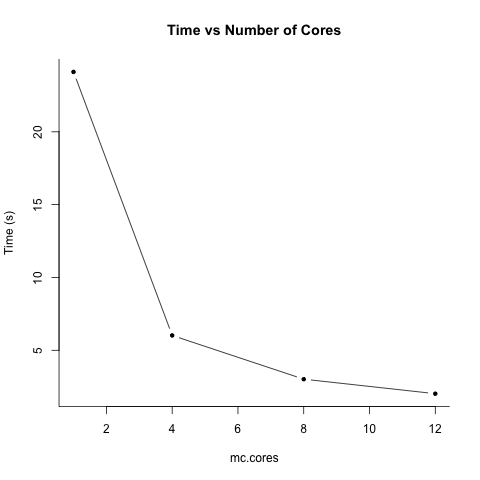

In [10]:
%%R
ts <- c(t1, t4, t8, t12)
cs <- c(1, 4, 8, 12)
plot(cs, ts, type = 'b', bty='l', xlab = "mc.cores", ylab = "Time (s)", pch = 20, main = "Time vs Number of Cores")

## Example
Try to use `mclapply()` on one of your own functions, both inside and outside of Rstudio. Do you notice any difference in speed? Note `mclapply()` only parallelises over one argument. For multivariate parallelisation, see `mcmapply()`.